In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import argparse
import random as random
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from torchvision.io import read_image
from collections import Counter
import seaborn as sns


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class Net(torch.nn.Module):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label




In [ ]:
# Creating more data samples for train and test
transform = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=np.array([0.5, 0.5, 0.5]),
                             std=np.array([0.25, 0.25, 0.25]))
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=np.array([0.5, 0.5, 0.5]),
                             std=np.array([0.25, 0.25, 0.25]))
    ]),

}

In [ ]:
data_dir = "/content/drive/My Drive/Dataset/archive/xray_dataset_covid19"

train_data = ImageFolder(os.path.join(data_dir, "train"), transform = transform["train"])
test_data = ImageFolder(os.path.join(data_dir, "test"), transform = transform["test"])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 148
    Root location: /content/drive/My Drive/Dataset/archive/xray_dataset_covid19/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )

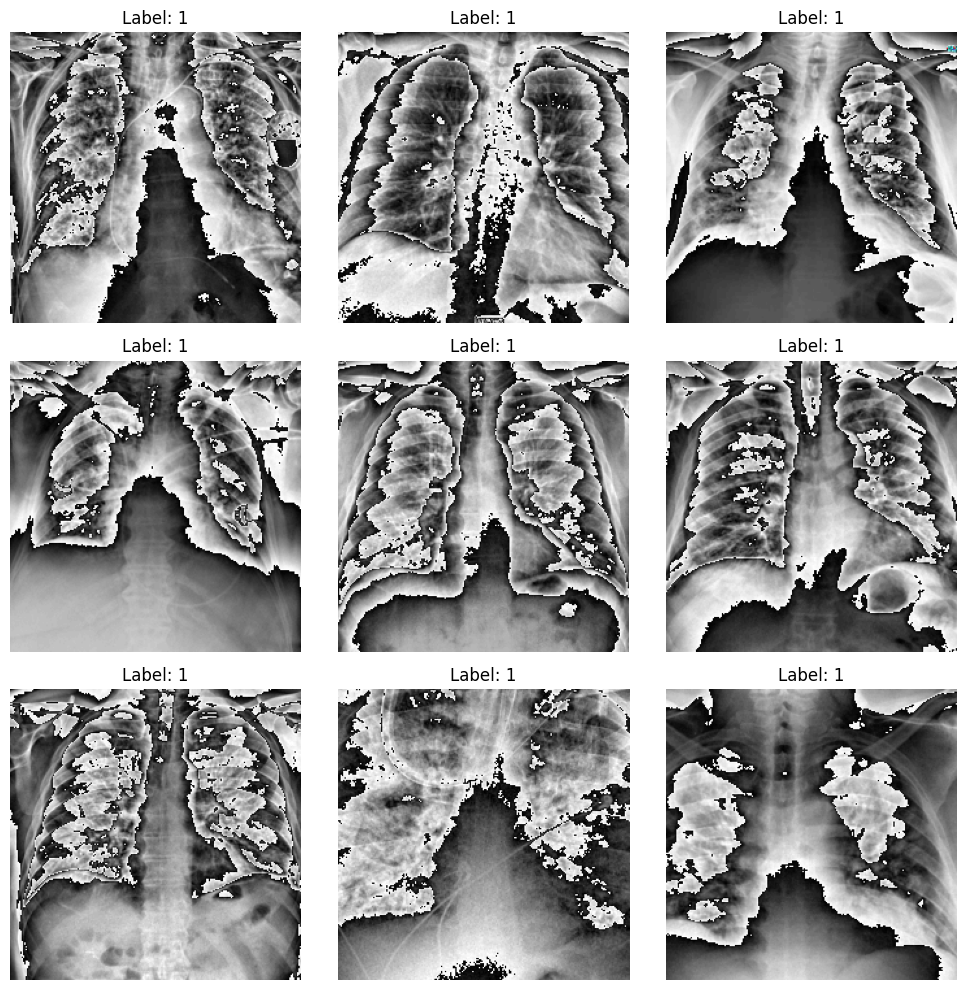

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    image, label = train_data[100 + i]


    image = transforms.ToPILImage()(image)


    row, col = divmod(i, 3)


    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')


plt.tight_layout()
plt.show()


In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print the shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(labels)

Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])


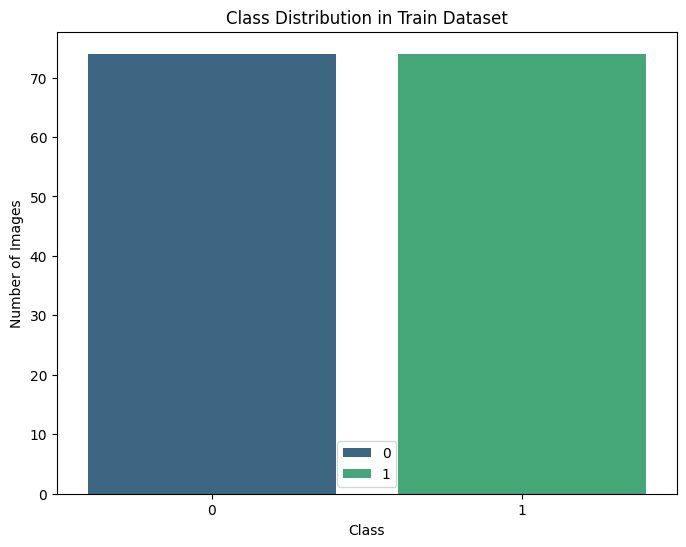

In [ ]:
class_labels = [label for _, label in train_data]
class_counts = Counter(class_labels)

labels = list(class_counts.keys())
counts = list(class_counts.values())

# Plotting the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=counts, palette="viridis", hue = labels)
plt.title("Class Distribution in Train Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks()
plt.show()

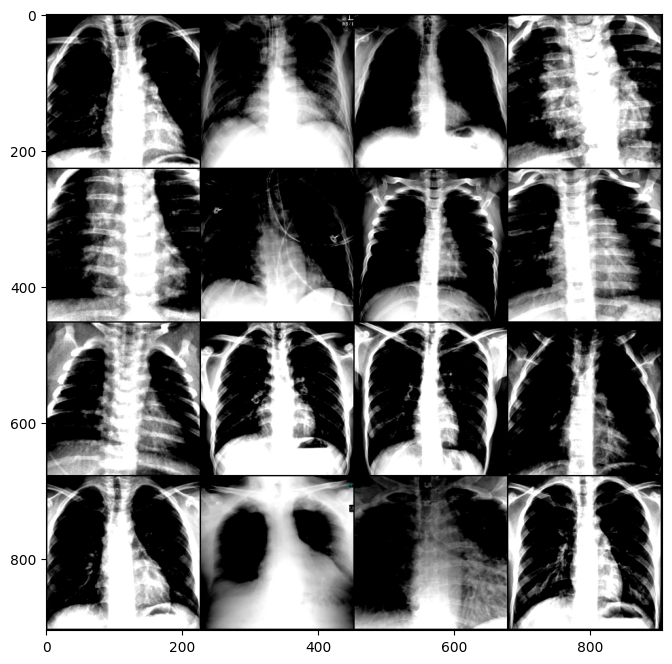

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
grid = torchvision.utils.make_grid(images, nrow=4)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
def validate(model, test_loader, criterion, device = device):
  model.eval()
  totalValLoss = 0.0
  valPredictions = 0
  totalSamples = 0
  all_labels = []
  all_predictions = []
  all_probs = []

  with torch.no_grad():
    for data, labels in test_loader:
      valInputs = data.to(device)
      valLabels = labels.to(device)
      valOutputs = model(valInputs)
      valLoss = criterion(valOutputs, valLabels)

      totalValLoss += valLoss.item()

      _, predictedVal = torch.max(valOutputs.data, 1)
      probabilities = torch.softmax(valOutputs, dim=1)[:, 1]
      valPredictions += (predictedVal == valLabels).sum().item()

      all_labels.extend(valLabels.cpu().numpy())
      all_predictions.extend(predictedVal.cpu().numpy())
      all_probs.extend(probabilities.cpu().numpy())

      totalSamples += valLabels.size(0)
  valAccuracy = valPredictions / totalSamples
  valLoss = totalValLoss / len(test_loader)


  cm = confusion_matrix(all_labels, all_predictions)
  TN, FP, FN, TP = cm.ravel()

  accuracy = (TP + TN) / (TP + TN + FP + FN)
  sensitivity = recall_score(all_labels, all_predictions)  # Same as recall
  specificity = TN / (TN + FP)
  precision = precision_score(all_labels, all_predictions)
  f1 = f1_score(all_labels, all_predictions)

  auc_score = roc_auc_score(all_labels, all_probs)
  fpr, tpr, _ = roc_curve(all_labels, all_probs)

  # avg_val_loss = total_val_loss / len(test_loader)

  return        valAccuracy,        valLoss,        sensitivity,      f1, cm, auc_score, fpr, tpr

In [ ]:
def maxpool_output_shape(inputHeight, inputWidth, poolSize = 2):
  outputHeight = int(inputHeight/poolSize)
  outputWidth = int(inputWidth/poolSize)
  return outputHeight, outputWidth

In [ ]:
def findConv2d_shape(height, width, conv):
  kernel_size = conv.kernel_size
  stride = conv.stride
  padding = conv.padding
  dilation = conv.dilation

  # Calculate output height and width
  height = np.floor((height + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
  width = np.floor((width + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

  return int(height), int(width)

In [ ]:
def train(model, train_loader, optimizer, criterion, scheduler=None,
          test_loader=None, epochs=10, device='cuda'):
    train_loss_lst, val_loss_lst = [], []
    for epoch in range(epochs):
        model.train()
        loss = 0.0
        trainPredictions = 0
        totalSamples = 0
        for data, labels in train_loader:
            inputs = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            trainLoss = criterion(outputs, labels)
            trainLoss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            loss += trainLoss.item()

            _, predicted = torch.max(outputs.data, 1)
            trainPredictions += (predicted == labels).sum().item()
            totalSamples += labels.size(0)

        trainAccuracy = trainPredictions / totalSamples
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {loss / len(train_loader):.3f}, Training Accuracy: {trainAccuracy * 100:.3f}%')

        if test_loader is not None:
            # Validation step using the callback
            val_accuracy, val_loss, recall, f1, cm, auc_score, fpr, tpr = validate(model, test_loader, criterion, device=device)
            print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}%, Recall: {recall:.3f}, F1: {f1:.3f}')
            print(f'Confusion Matrix:\n{cm}')

        train_loss_lst.append(loss / len(train_loader))
        val_loss_lst.append(val_loss if test_loader is not None else None)

    print('Training finished')
    return cm, auc_score, fpr, tpr, train_loss_lst, val_loss_lst


In [ ]:
# distribution of classes
# confusion matrix for both models
# auc-roc curve

In [ ]:
config = {
    "input_shape": (3, 224, 224),
    "classes": 2
}

In [ ]:
randomSeed = 37
random.seed(randomSeed)
torch.manual_seed(randomSeed)


class CNN(torch.nn.Module):
    def __init__(self, config):
        super(CNN, self).__init__()
        conv, height, width = config["input_shape"]
        classes = config["classes"]

        # Block 1: Conv -> ReLU -> BatchNorm -> Conv -> ReLU -> BatchNorm -> MaxPool
        self.conv1 = torch.nn.Conv2d(conv, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(32)

        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(64)

        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        height, width = maxpool_output_shape(*findConv2d_shape(*findConv2d_shape(height, width, self.conv1), self.conv2), 2)

        # Block 2: Conv -> ReLU -> BatchNorm -> Conv -> ReLU -> BatchNorm -> MaxPool
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(128)

        self.conv4 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(256)

        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        height, width = maxpool_output_shape(*findConv2d_shape(*findConv2d_shape(height, width, self.conv3), self.conv4), 2)

        # Block 3: Conv -> ReLU -> BatchNorm -> Dropout -> MaxPool
        self.conv5 = torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.relu5 = torch.nn.ReLU()
        self.bn5 = torch.nn.BatchNorm2d(512)
        self.dropout1 = torch.nn.Dropout(0.5)

        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        height, width = maxpool_output_shape(*findConv2d_shape(height, width, self.conv5), 2)

        # Fully connected layers
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(512 * height * width, 512)
        self.relu_fc1 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(0.5)

        self.fc2 = torch.nn.Linear(512, 128)
        self.relu_fc2 = torch.nn.ReLU()

        self.fc3 = torch.nn.Linear(128, classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)

        x = self.maxpool1(x)

        # Block 2
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)

        x = self.maxpool2(x)

        # Block 3
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.bn5(x)
        x = self.dropout1(x)

        x = self.maxpool3(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = self.relu_fc2(x)

        x = self.fc3(x)
        return x


In [ ]:
model = CNN(config).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [ ]:
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 64, 224, 224]          18,496
              ReLU-5         [-1, 64, 224, 224]               0
       BatchNorm2d-6         [-1, 64, 224, 224]             128
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
              ReLU-9        [-1, 128, 112, 112]               0
      BatchNorm2d-10        [-1, 128, 112, 112]             256
           Conv2d-11        [-1, 256, 112, 112]         295,168
             ReLU-12        [-1, 256, 112, 112]               0
      BatchNorm2d-13        [-1, 256, 112, 112]             512
        MaxPool2d-14          [-1, 256,

Epoch [1/50], Training Loss: 1.336, Training Accuracy: 74.324%
Epoch [1/50], Validation Loss: 3.968, Validation Accuracy: 0.500%, Recall: 1.000, F1: 0.667
Confusion Matrix:
[[ 0 20]
 [ 0 20]]
Epoch [2/50], Training Loss: 0.924, Training Accuracy: 81.081%
Epoch [2/50], Validation Loss: 4.813, Validation Accuracy: 0.500%, Recall: 1.000, F1: 0.667
Confusion Matrix:
[[ 0 20]
 [ 0 20]]
Epoch [3/50], Training Loss: 0.734, Training Accuracy: 83.784%
Epoch [3/50], Validation Loss: 3.217, Validation Accuracy: 0.500%, Recall: 1.000, F1: 0.667
Confusion Matrix:
[[ 0 20]
 [ 0 20]]
Epoch [4/50], Training Loss: 0.571, Training Accuracy: 81.081%
Epoch [4/50], Validation Loss: 0.992, Validation Accuracy: 0.500%, Recall: 1.000, F1: 0.667
Confusion Matrix:
[[ 0 20]
 [ 0 20]]
Epoch [5/50], Training Loss: 0.825, Training Accuracy: 87.162%
Epoch [5/50], Validation Loss: 0.940, Validation Accuracy: 0.600%, Recall: 1.000, F1: 0.714
Confusion Matrix:
[[ 4 16]
 [ 0 20]]
Epoch [6/50], Training Loss: 0.950, Trai

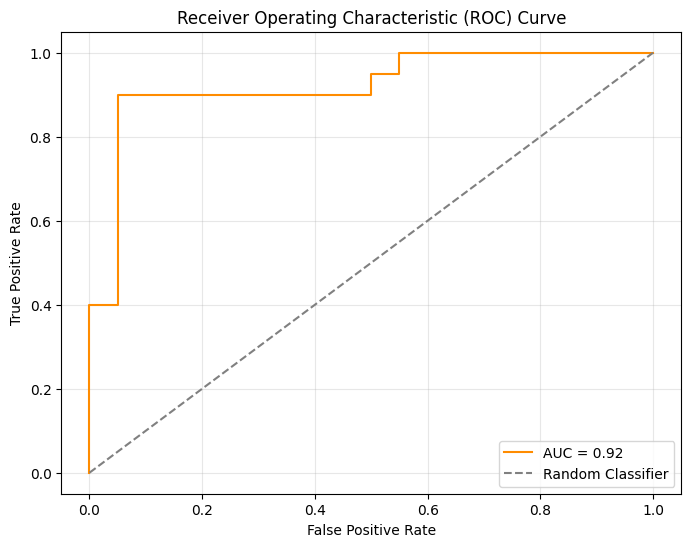

In [ ]:
cm, auc_score, fpr, tpr, train_loss, val_loss = train(model, train_loader, optimizer, criterion,
          scheduler=scheduler, test_loader=test_loader, epochs=50, device=device)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
train_loss

[1.3361808769404888,
 0.9235987754538655,
 0.7341825723648071,
 0.5710559902712703,
 0.825118905492127,
 0.9497343242168427,
 0.6691149530699476,
 0.6291527165099978,
 1.1198962807655335,
 1.0429854530841112,
 0.6609725996851921,
 0.8656184867024421,
 0.6136608011787757,
 0.7319121018052102,
 0.9744920006021858,
 0.773644107952714,
 1.0902864694595338,
 0.8455421835184097,
 0.824142451398069,
 0.42894458286464215,
 0.5321691377088428,
 0.8613124989904464,
 1.0094444138929248,
 0.5427008620463312,
 0.5850409775972366,
 0.7069656640291214,
 0.5067650627344846,
 0.3966755921952426,
 0.9179850131273269,
 1.0726637287298217,
 0.6772942185401917,
 0.8018141315245885,
 0.9362174898386002,
 0.8015990700572729,
 0.6283002486918121,
 0.7580298393964767,
 0.6733166143298149,
 0.9091163575649261,
 0.9055947863031178,
 0.6150619432330131,
 0.8575185790657998,
 1.145207080245018,
 0.8220237919129432,
 0.48897023368626835,
 1.1771462202072143,
 0.5482899473048747,
 0.9152384832501411,
 0.711685159243

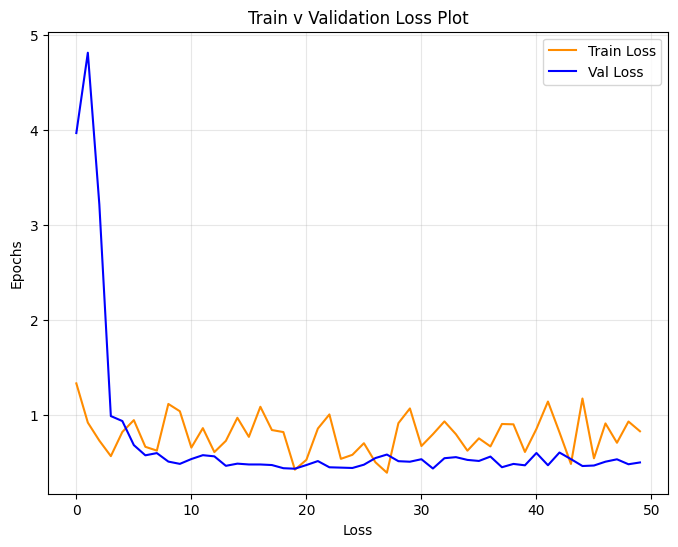

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label=f'Train Loss', color='darkorange')
plt.plot(val_loss, label=f'Val Loss', color='blue')
# plt.plot([0, 1], [0, 1], linestyle='--', color='blue', label='Random Classifier')
plt.title('Train v Validation Loss Plot')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()

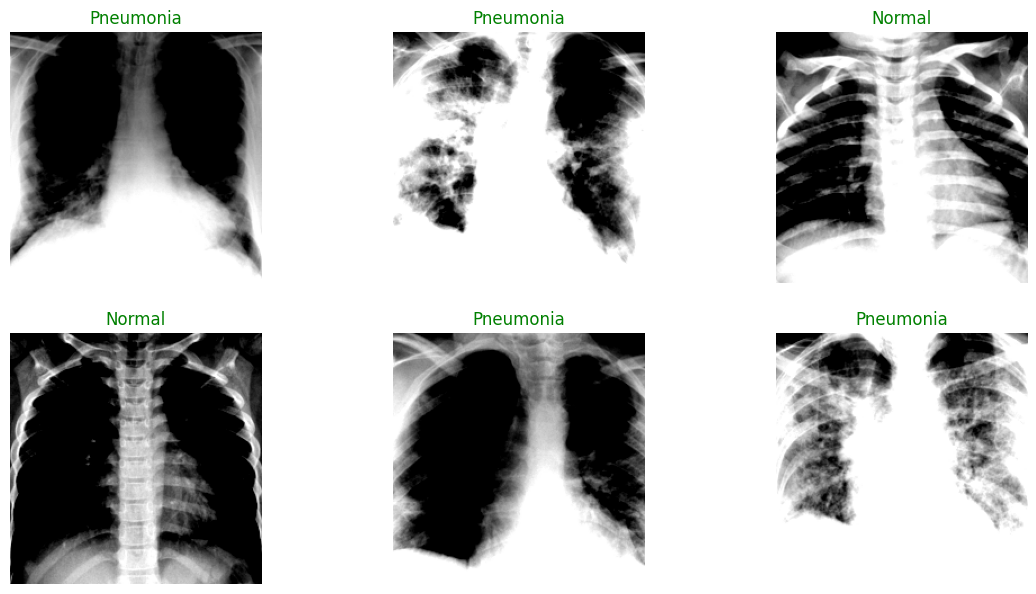

In [ ]:
_def plot_prediction_CNN(model, test_loader, class_names, device, n_images):
    """
    Test the model on random predictions
    Args:
    model: the trained model
    test_loader: DataLoader instance for the test dataset
    class_names: list of class names
    device: the device on which to run the model (e.g., 'cuda' or 'cpu')
    n_images: number of images to plot
    """
    model.eval()
    with torch.no_grad():
        fig = plt.figure(figsize=(14, 15))
        for i, (images, labels) in enumerate(test_loader):
            if i >= n_images:
                break
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for j in range(images.shape[0]):
                if i >= n_images:
                    break
                plt.subplot(4, 3, i + 1)
                image = images.cpu().numpy()[j].transpose(1, 2, 0)
                label = labels.cpu().numpy()[j]
                prediction = predictions.cpu().numpy()[j]
                plt.imshow(image)
                if prediction == label:
                    title_obj = plt.title(class_names[label])
                    plt.setp(title_obj, color='g')
                else:
                    title_obj = plt.title(class_names[label] + ' Misclassified as ' + class_names[prediction])
                    plt.setp(title_obj, color='r')
                plt.axis('off')
                i += 1
        plt.show()


class_names = ['Normal','Pneumonia']
plot_prediction_CNN(resnet18_model, test_loader=test_loader, class_names=class_names, device=device, n_images=6)

ResNet 18 Model

In [ ]:
resnet18_model = models.resnet18(weights=True)

num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(num_ftrs,2)
resnet18_model.to(device)
criterion_resnet = torch.nn.CrossEntropyLoss()

# Set up the optimizer for training.
optimizer_resnet = torch.optim.SGD(resnet18_model.parameters(), lr=0.001)
print(resnet18_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch [1/10], Training Loss: 0.154, Training Accuracy: 98.649%
Epoch [1/10], Validation Loss: 0.164, Validation Accuracy: 0.925%, Recall: 0.900, F1: 0.923
Confusion Matrix:
[[19  1]
 [ 2 18]]
Epoch [2/10], Training Loss: 0.090, Training Accuracy: 99.324%
Epoch [2/10], Validation Loss: 0.170, Validation Accuracy: 0.925%, Recall: 0.900, F1: 0.923
Confusion Matrix:
[[19  1]
 [ 2 18]]
Epoch [3/10], Training Loss: 0.135, Training Accuracy: 97.297%
Epoch [3/10], Validation Loss: 0.171, Validation Accuracy: 0.925%, Recall: 0.900, F1: 0.923
Confusion Matrix:
[[19  1]
 [ 2 18]]
Epoch [4/10], Training Loss: 0.062, Training Accuracy: 99.324%
Epoch [4/10], Validation Loss: 0.180, Validation Accuracy: 0.925%, Recall: 0.900, F1: 0.923
Confusion Matrix:
[[19  1]
 [ 2 18]]
Epoch [5/10], Training Loss: 0.077, Training Accuracy: 100.000%
Epoch [5/10], Validation Loss: 0.180, Validation Accuracy: 0.925%, Recall: 0.900, F1: 0.923
Confusion Matrix:
[[19  1]
 [ 2 18]]
Epoch [6/10], Training Loss: 0.070, Tra

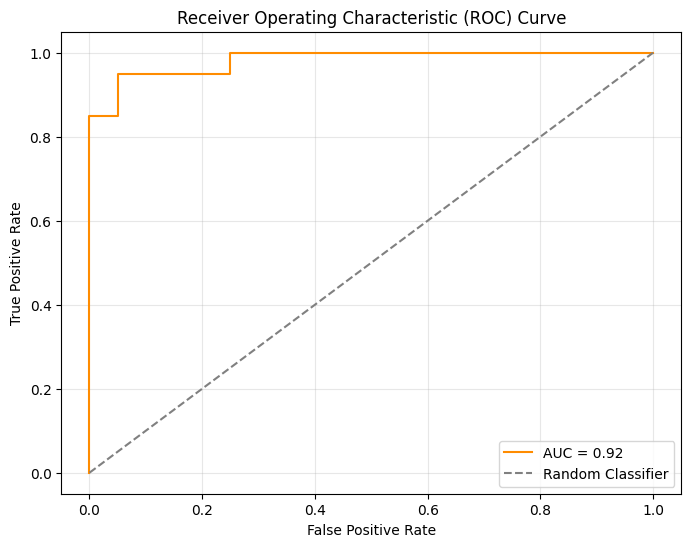

In [ ]:
cm18, auc_score18, fpr18, tpr18, trainloss18, valloss18 = train(resnet18_model, train_loader, optimizer_resnet, criterion_resnet, scheduler=scheduler,
          test_loader=test_loader, epochs=10, device=device)
plt.figure(figsize=(8, 6))
plt.plot(fpr18, tpr18, label=f'AUC = {auc_score:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

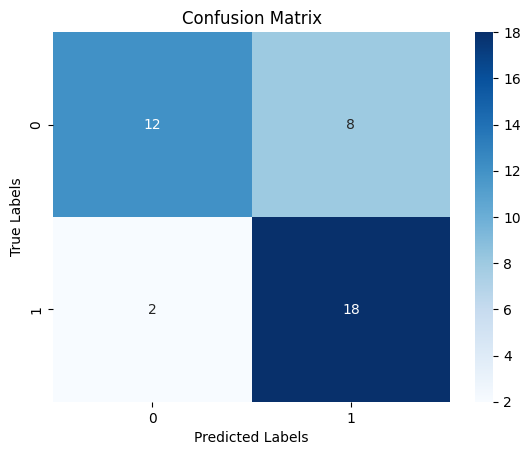

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
trainloss18

[0.15398926958441733,
 0.09011696688830853,
 0.13476781286299228,
 0.062122220173478127,
 0.07728710491210222,
 0.06962307784706354,
 0.06109517253935337,
 0.04386834967881441,
 0.06923875696957112,
 0.08180190473794938]

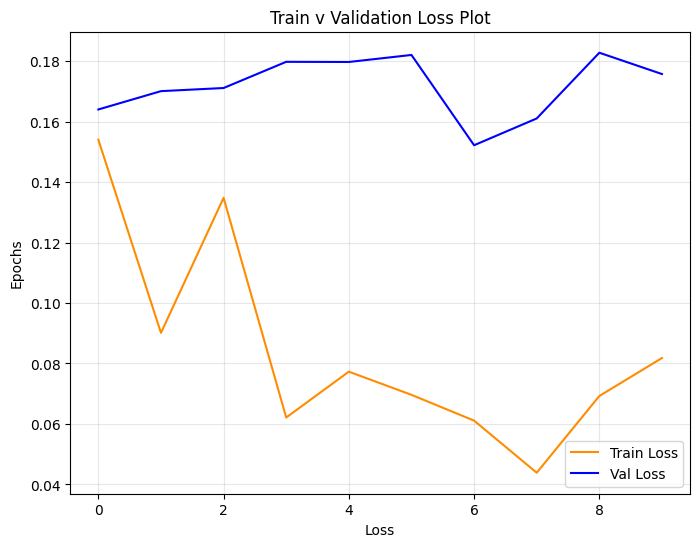

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(trainloss18, label=f'Train Loss', color='darkorange')
plt.plot(valloss18, label=f'Val Loss', color='blue')
# plt.plot([0, 1], [0, 1], linestyle='--', color='blue', label='Random Classifier')
plt.title('Train v Validation Loss Plot')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()